## Notebook for training for option spread with rolling forecast
Forecast for last 10% of data. Forecast is done day by day.
- Sequential model
- LSTM model
- not stationary
- rolling forecast

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as si
from IPython.display import Image
import datetime
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing, metrics

%matplotlib inline

In [18]:
backup = pd.HDFStore('backup_v09.h5')
#df = backup['df']
#unscaled_seq_predictions = backup['unscaled_seq_predictions']
#unscaled_data = backup['unscaled_data']
#unscaled_lstm_predictions = backup['unscaled_lstm_predictions']
#test_data_unscaled = backup['test_data_unscaled']

### Iron Condor
The iron condor is a investment strategy using four option with the same strike date. More precise, the iron condor uses two vertical spreads, one put spread and a call spread. The put spread consists at of a short put option (P_s) with a strike price below the actual stock price and a long put option (P_l) with a strike price below the short put option P_s. The call spread consists of a short call option (C_s) above the actual stock price and a long call option (C_l) above the short call option C_s. All options have the same strike date and the spread on both legs can vary but is chosen mostly the same.
![title](Condor_strategy.png)
"A trader who buys an iron condor speculates that the spot price of the underlying instrument will be between the short strikes when the options expire where the position is the most profitable. Thus, the iron condor is an options strategy considered when the trader has a neutral outlook for the market. Buying iron condors are popular with traders who seek regular income from their trading capital. An iron condor buyer will attempt to construct the trade so that the short strikes are close enough that the position will earn a desirable net credit, but wide enough apart so that it is likely that the spot price of the underlying will remain between the short strikes for the duration of the options contract. The trader would typically play iron condors every month (if possible) thus generating monthly income with the strategy." [https://en.wikipedia.org/wiki/Iron_condor]

### Goal of the project
The goal of the project is to find a strategy to maximise the profit with an iron condor. The ideal short and long spreads should be found at any time based on data of the underlying stock and of the indices S&P500 and Nasdaq

In [19]:
def get_data(var_name,name):
    # reads in csv into DataFrame, keeps Adj Close and Volume and calculates rolling averages and 
    # rolling standard deviation of Adj Close for 4, 9 and 18 days
    # var_name: path to csv file
    # name: name of the column df
    df = pd.read_csv('data/'+var_name+'.csv',index_col='Date', parse_dates=True)
    df.rename(columns={"Adj Close": name, "Volume": name+'_volume', "Open": name+'_open'}, inplace = True)
    df.rename(columns={"High": name+'_high', "Low": name+'_low', "Close": name+'_close'}, inplace = True)
    #df.drop(['Open','High','Low','Close'],axis=1, inplace = True)
    #if name == 'google':
        #df['google_45d'] = df['google'].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df[name+'_ra_04'] = df[name].rolling('4d').mean()
    df[name+'_std_04'] = df[name].rolling('4d').std()
    df[name+'_ra_09'] = df[name].rolling('9d').mean()
    df[name+'_std_09'] = df[name].rolling('9d').std()
    df[name+'_ra_18'] = df[name].rolling('18d').mean()
    df[name+'_std_18'] = df[name].rolling('18d').std()
    return df

In [20]:
def sigma_fct(df, name, days = 10):
    # For Black-Scholes I need the volatility of return of the underlying assets in the last days
    # based on https://www.wikihow.com/Calculate-Historical-Stock-Volatility
    # First the ln of daily returns is calculated for each element of names
    for name in names:
        a=pd.DataFrame()
        a['ln_daily_return'] = np.log(df[name] / df[name].shift(1))
        # next the rolling average (mean) over certain days is calculated
        a['rol_avg'] =  a['ln_daily_return'].rolling(str(days)+'d').mean()
        # next deviation from the mean is calculated
        a['dev_mean'] = a['ln_daily_return'] - a['rol_avg']
        # next variance is calculated for certain days
        a['dev_mean_sq'] = a['dev_mean']**2
        a['variance'] = a['dev_mean_sq'].rolling(str(days)+'d').sum()/(a['dev_mean_sq'].rolling(str(days)+'d').count()-1)
        # volatility is square root of variance
        # do you need annual volatility?
        df[name + '_daily_vol'] = np.sqrt(a['variance'])*np.sqrt(252) # 252 trading days in a year
        #df.drop(['ln_daily_return'])#,'rol_avg','dev_mean','dev_mean_sq','variance'])
        #return df[name + '_daily_vol']
    return df

In [21]:
def stationary_timeseries(df, damned_list = ['volume','std','short','daily']):
    # makes columns in df that are not in damned list stationary. Means it calculates the 
    # difference row by row
    columns = df.columns
    df_sta = pd.DataFrame()
    for column in columns:
        if any(elem in column for elem in damned_list):
            df_sta[column] = df[column]
        else:
            df_sta[column+'_sta'] = df[column] - df[column].shift(1)
    df_sta.dropna(inplace = True)  # to make sure we have all the data on all the days
    return df_sta

In [22]:
def get_df(var_name_list,name_list):
    # takes list paths of csv files and names and passes it on to get_data.
    # Gets df from get_data and merges them on 'Date'
    # Calls sigma_fct to get sigma of daily returns 
    # var_name_list: list of paths to csv files
    # name: list of names the columns of df
    i=0
    for var_name in var_name_list:
        if i == 0:
            df = get_data(var_name, name_list[i])
        else:
            df = pd.merge(df,get_data(var_name, name_list[i]),on='Date')
        i += 1
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    
    df = sigma_fct(df,names)
    df=df[23:] # drop first entries to get clean results

    return df

In [23]:
def get_target_data(df, name):
    # function to create the target data
    # name: name of the column the target data is created of
    df[name+'_45d'] = df[name].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    # df['short_call'] shows the perfect short call. If you would have shorted a call option with a strike price 
    # exactly the same as the stock price 45 days later, you made maximum profit. Therefore this is the target 
    # value for the short call option. The minimum is 0, so we never short a call option with a strike price
    # below the stock price right now. The same for the short put option
    df['short_call'] = [x/y-1 if x/y > 1 else 0 for x,y in df[[name+'_45d', name]].values]
    df['short_put'] = [1-x/y if x/y < 1 else 0 for x,y in df[[name+'_45d', name]].values]
    return df

In [24]:
var_names = ['GOOG','S&P','Nasdaq2']
names = ['google','s&p','nasdaq']
df = get_df(var_names, names)
df = get_target_data(df, 'google')
df.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d,short_call,short_put
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-21,130.764862,134.182053,123.188263,130.725006,130.725006,20565700,136.935478,8.750923,143.875715,10.798013,...,1452.251430,95.188063,1541.462141,127.530682,0.716470,0.802275,0.738519,156.946732,0.200587,0.0
2008-11-24,134.127258,134.470963,124.040070,128.239334,128.239334,20184700,129.482170,1.757636,137.580147,9.599201,...,1420.705017,68.914436,1498.502503,101.345711,0.529842,0.864400,0.777819,155.761169,0.214613,0.0
2008-11-25,133.838348,142.794769,133.160873,140.498383,140.498383,21623100,134.368858,8.668457,137.997038,8.831976,...,1426.994298,65.073432,1483.279999,90.035297,0.833833,0.791313,0.710049,156.573120,0.114412,0.0
2008-11-26,139.616684,147.178345,137.584305,145.499634,145.499634,12760800,138.079117,8.880829,137.425609,8.059325,...,1434.144287,74.235572,1487.035382,87.259170,0.812863,0.758392,0.707779,149.923050,0.030402,0.0
2008-11-28,144.747452,147.671494,143.601746,145.933014,145.933014,5150200,143.977010,3.020363,136.698456,8.236770,...,1450.814982,86.016593,1480.791532,79.789023,0.871477,0.804582,0.756923,148.936752,0.020583,0.0


In [25]:
backup['df'] = df

### Price of options
It is really hard to get data about historic stock options. Be it as api channel or csv download. I managed only to find sources to pay: 500 USD for every year. Because that is too expensive for this project I decided to calculate the option price with the **Black–Scholes formula**, which gives a theoretical estimate of the price of European-style options.

Based on the formula for non-divident paying options I calculate the option prices and add a small random term to create a bit of noise.

In [26]:
def black_scholes(S, K, sigma, r=0.03, T=45/365, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity in years, 45 days as default
    #r: risk-free interest rate, assumed to be constant between t and T
    #sigma: standard deviation (volatility) of RETURNS of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    #d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [27]:
def option_prices(date, short_spread, long_spread, strike_days = 45):
    # calculates prices of options and calculates initial return (net premium)
    date = date_fct(date)
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(date, short_spread, long_spread)
    sigma = get_sigma(date)
    stock_price = stock_price_fct(date)
    P_s_price = black_scholes(stock_price, P_s_strike_price, sigma, T=strike_days/365, option = 'put')
    P_l_price = black_scholes(stock_price, P_l_strike_price, sigma, T=strike_days/365, option = 'put')
    C_s_price = black_scholes(stock_price, C_s_strike_price, sigma, T=strike_days/365, option = 'call')
    C_l_price = black_scholes(stock_price, C_l_strike_price, sigma, T=strike_days/365, option = 'call')
    initial_return = P_s_price + C_s_price - P_l_price - C_l_price
    
    return P_s_price, P_l_price, C_s_price, C_l_price, initial_return

Now it is time to calculate the strike prices and option prices of all 4 options and the initial return by setting up the iron condor

### Calculate return of options
There are five different regimes for the return. R: return, P(C) put(call) option, s(l): short(long), ir: initial return, stock_price: stock price
- stock price is below long put option: R = ir + P_l_strike_price - P_s_strike_price
- stock price is between long and short put option: R = ir + stock_price - P_s_strike_price
- stock price is between short call and short put option: R = ir
- stock price is between short and long call option: R = ir - stock_price + C_s_strike price
- stock price is above long call option: R = ir - C_l_strike_price + C_s_strike_price

#### Define return function of iron condor

In [28]:
def ic_return(trading_date, short_spread, long_spread, strike_days = 45):
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(trading_date, short_spread, long_spread)
    P_s_price, P_l_price, C_s_price, C_l_price, initial_return = option_prices(trading_date,short_spread, long_spread, strike_days)
    strike_date = date_fct(trading_date, 45)
    final_stock_price = stock_price_fct(strike_date)
    if final_stock_price < P_l_strike_price:
        final_result = initial_return + P_l_strike_price - P_s_strike_price
    elif final_stock_price >= P_l_strike_price and final_stock_price < P_s_strike_price:
        final_result = initial_return + stock_price - P_s_strike_price
    elif final_stock_price >= P_s_strike_price and final_stock_price < C_s_strike_price:
        final_result = initial_return
    elif final_stock_price >= C_s_strike_price and final_stock_price < C_l_strike_price:
        final_result = initial_return - final_stock_price + C_s_strike_price
    elif final_stock_price >= C_l_strike_price:
        final_result = initial_return - C_l_strike_price + C_s_strike_price
    maximum_result = initial_return
    return final_result

### Building the model

#### Scale data

In [29]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)

/home/matthias/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split into train and test set

In [30]:
def get_train_test_data(data, train_test_split, batch_size):
    # data is dataframe to get train test data out of
    train_size_raw = data.shape[0]*train_test_split
    train_size = int(train_size_raw - train_size_raw % batch_size) # make train_size multiple of batch_size for "statefull = True" in LSTM
    train_data = data.iloc[0:train_size]
    test_size_raw = data.shape[0] - train_size
    test_size = int(test_size_raw - test_size_raw%batch_size) # multiple of batch_size
    test_data = data.iloc[train_size : train_size + test_size]
    x_train = train_data.drop(columns=['google_45d','short_call','short_put']) # google_45d is not for training, just for reversing stationarity
    y_train = train_data[['short_call','short_put']]
    x_test = test_data.drop(columns=['google_45d','short_call','short_put'])
    y_test = test_data[['short_call','short_put']]
    train_index=x_train.index
    x_columns = x_train.columns
    test_index = x_test.index
    return x_train, x_test, y_train, y_test, test_data, test_index, x_columns

In [31]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

### Sequential model

In [32]:
# Build the model architecture
seq_model = Sequential()
seq_model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(16, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(4, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(2))

# Compile the model using a loss function and an optimizer.
seq_model.compile(optimizer='adam',loss='mean_squared_error')
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
Total para

In [33]:
start_seq = time.time()
history=seq_model.fit(x_train, y_train, epochs=3000, batch_size=50, verbose=1, validation_data=(x_test, y_test));
end_seq = time.time()
time_seq = end_seq - start_seq
time_seq


Train on 2370 samples, validate on 270 samples
Epoch 1/3000
2370/2370 [==============================] - 1s 319us/step - loss: 0.4390 - val_loss: 0.1661
Epoch 2/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.2849 - val_loss: 0.1542
Epoch 3/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.2557 - val_loss: 0.1642
Epoch 4/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.2361 - val_loss: 0.1528
Epoch 5/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.2220 - val_loss: 0.1556
Epoch 6/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.2110 - val_loss: 0.1686
Epoch 7/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.2022 - val_loss: 0.1604
Epoch 8/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.1928 - val_loss: 0.1528
Epoch 9/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.1869 - val_loss: 0.1594
Epoch 

Epoch 76/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.1163 - val_loss: 0.1447
Epoch 77/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.1161 - val_loss: 0.1473
Epoch 78/3000
2370/2370 [==============================] - 0s 40us/step - loss: 0.1153 - val_loss: 0.1668
Epoch 79/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.1167 - val_loss: 0.1507
Epoch 80/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.1164 - val_loss: 0.1406
Epoch 81/3000
2370/2370 [==============================] - 0s 93us/step - loss: 0.1150 - val_loss: 0.1413
Epoch 82/3000
2370/2370 [==============================] - 0s 110us/step - loss: 0.1145 - val_loss: 0.1456
Epoch 83/3000
2370/2370 [==============================] - 0s 61us/step - loss: 0.1152 - val_loss: 0.1413
Epoch 84/3000
2370/2370 [==============================] - 0s 55us/step - loss: 0.1145 - val_loss: 0.1562
Epoch 85/3000
2370/2370 [====================

2370/2370 [==============================] - 0s 91us/step - loss: 0.1042 - val_loss: 0.1390
Epoch 153/3000
2370/2370 [==============================] - 0s 41us/step - loss: 0.1041 - val_loss: 0.1423
Epoch 154/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.1054 - val_loss: 0.1535
Epoch 155/3000
2370/2370 [==============================] - 0s 91us/step - loss: 0.1050 - val_loss: 0.1484
Epoch 156/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.1050 - val_loss: 0.1766
Epoch 157/3000
2370/2370 [==============================] - 0s 123us/step - loss: 0.1028 - val_loss: 0.1480
Epoch 158/3000
2370/2370 [==============================] - 0s 103us/step - loss: 0.1038 - val_loss: 0.1508
Epoch 159/3000
2370/2370 [==============================] - 0s 108us/step - loss: 0.1038 - val_loss: 0.1620
Epoch 160/3000
2370/2370 [==============================] - 0s 84us/step - loss: 0.1056 - val_loss: 0.1441
Epoch 161/3000
2370/2370 [=======================

2370/2370 [==============================] - 0s 50us/step - loss: 0.0990 - val_loss: 0.1543
Epoch 229/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0986 - val_loss: 0.1351
Epoch 230/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0995 - val_loss: 0.1412
Epoch 231/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0980 - val_loss: 0.1631
Epoch 232/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0998 - val_loss: 0.1497
Epoch 233/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.1004 - val_loss: 0.1618
Epoch 234/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.1012 - val_loss: 0.1418
Epoch 235/3000
2370/2370 [==============================] - 0s 61us/step - loss: 0.0992 - val_loss: 0.1352
Epoch 236/3000
2370/2370 [==============================] - 0s 86us/step - loss: 0.0990 - val_loss: 0.1529
Epoch 237/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 34us/step - loss: 0.0969 - val_loss: 0.1366
Epoch 305/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0944 - val_loss: 0.1391
Epoch 306/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0958 - val_loss: 0.1429
Epoch 307/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0942 - val_loss: 0.1470
Epoch 308/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0953 - val_loss: 0.1630
Epoch 309/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0958 - val_loss: 0.1381
Epoch 310/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0961 - val_loss: 0.1398
Epoch 311/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0950 - val_loss: 0.1511
Epoch 312/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0957 - val_loss: 0.1473
Epoch 313/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 40us/step - loss: 0.0938 - val_loss: 0.1395
Epoch 381/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0938 - val_loss: 0.1732
Epoch 382/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0946 - val_loss: 0.1399
Epoch 383/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0932 - val_loss: 0.1359
Epoch 384/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0950 - val_loss: 0.1459
Epoch 385/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0940 - val_loss: 0.1475
Epoch 386/3000
2370/2370 [==============================] - 0s 37us/step - loss: 0.0921 - val_loss: 0.1478
Epoch 387/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0945 - val_loss: 0.1391
Epoch 388/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0943 - val_loss: 0.1419
Epoch 389/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 33us/step - loss: 0.0951 - val_loss: 0.1415
Epoch 457/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0914 - val_loss: 0.1394
Epoch 458/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0933 - val_loss: 0.1470
Epoch 459/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0907 - val_loss: 0.1387
Epoch 460/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0947 - val_loss: 0.1480
Epoch 461/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0920 - val_loss: 0.1420
Epoch 462/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0933 - val_loss: 0.1435
Epoch 463/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0924 - val_loss: 0.1468
Epoch 464/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0924 - val_loss: 0.1440
Epoch 465/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 28us/step - loss: 0.0913 - val_loss: 0.1408
Epoch 533/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0918 - val_loss: 0.1463
Epoch 534/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0900 - val_loss: 0.1547
Epoch 535/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0898 - val_loss: 0.1560
Epoch 536/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0895 - val_loss: 0.1418
Epoch 537/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0906 - val_loss: 0.1509
Epoch 538/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0904 - val_loss: 0.1505
Epoch 539/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0899 - val_loss: 0.1599
Epoch 540/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0911 - val_loss: 0.1463
Epoch 541/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 88us/step - loss: 0.0919 - val_loss: 0.1428
Epoch 609/3000
2370/2370 [==============================] - 0s 41us/step - loss: 0.0922 - val_loss: 0.1504
Epoch 610/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0903 - val_loss: 0.1373
Epoch 611/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0886 - val_loss: 0.1321
Epoch 612/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0915 - val_loss: 0.1415
Epoch 613/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0909 - val_loss: 0.1392
Epoch 614/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0876 - val_loss: 0.1391
Epoch 615/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0921 - val_loss: 0.1397
Epoch 616/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0901 - val_loss: 0.1447
Epoch 617/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 36us/step - loss: 0.0882 - val_loss: 0.1420
Epoch 685/3000
2370/2370 [==============================] - 0s 38us/step - loss: 0.0861 - val_loss: 0.1398
Epoch 686/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0914 - val_loss: 0.1478
Epoch 687/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0881 - val_loss: 0.1458
Epoch 688/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0859 - val_loss: 0.1427
Epoch 689/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0900 - val_loss: 0.1388
Epoch 690/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0891 - val_loss: 0.1365
Epoch 691/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0856 - val_loss: 0.1462
Epoch 692/3000
2370/2370 [==============================] - 0s 56us/step - loss: 0.0889 - val_loss: 0.1396
Epoch 693/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 34us/step - loss: 0.0866 - val_loss: 0.1481
Epoch 761/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0868 - val_loss: 0.1458
Epoch 762/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0849 - val_loss: 0.1480
Epoch 763/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0872 - val_loss: 0.1542
Epoch 764/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0869 - val_loss: 0.1432
Epoch 765/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0869 - val_loss: 0.1432
Epoch 766/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0872 - val_loss: 0.1484
Epoch 767/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0890 - val_loss: 0.1464
Epoch 768/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0878 - val_loss: 0.1427
Epoch 769/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0877 - val_loss: 0.1461
Epoch 837/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0867 - val_loss: 0.1732
Epoch 838/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0871 - val_loss: 0.1512
Epoch 839/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0849 - val_loss: 0.1459
Epoch 840/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0883 - val_loss: 0.1417
Epoch 841/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0854 - val_loss: 0.1452
Epoch 842/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0857 - val_loss: 0.1681
Epoch 843/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0874 - val_loss: 0.1423
Epoch 844/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0871 - val_loss: 0.1365
Epoch 845/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0839 - val_loss: 0.1533
Epoch 913/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0860 - val_loss: 0.1439
Epoch 914/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0836 - val_loss: 0.1409
Epoch 915/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0841 - val_loss: 0.1568
Epoch 916/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0849 - val_loss: 0.1423
Epoch 917/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0851 - val_loss: 0.1569
Epoch 918/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0876 - val_loss: 0.1394
Epoch 919/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0865 - val_loss: 0.1490
Epoch 920/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1383
Epoch 921/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 30us/step - loss: 0.0841 - val_loss: 0.1612
Epoch 989/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0836 - val_loss: 0.1432
Epoch 990/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0862 - val_loss: 0.1523
Epoch 991/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0860 - val_loss: 0.1477
Epoch 992/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0846 - val_loss: 0.1697
Epoch 993/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0832 - val_loss: 0.1461
Epoch 994/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0829 - val_loss: 0.1488
Epoch 995/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0837 - val_loss: 0.1507
Epoch 996/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0838 - val_loss: 0.1489
Epoch 997/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 30us/step - loss: 0.0835 - val_loss: 0.1365
Epoch 1065/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0849 - val_loss: 0.1460
Epoch 1066/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0841 - val_loss: 0.1368
Epoch 1067/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0865 - val_loss: 0.1547
Epoch 1068/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0852 - val_loss: 0.1451
Epoch 1069/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0839 - val_loss: 0.1520
Epoch 1070/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0828 - val_loss: 0.1652
Epoch 1071/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0843 - val_loss: 0.1462
Epoch 1072/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0822 - val_loss: 0.1414
Epoch 1073/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 30us/step - loss: 0.0818 - val_loss: 0.1362
Epoch 1141/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0812 - val_loss: 0.1446
Epoch 1142/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0807 - val_loss: 0.1547
Epoch 1143/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0834 - val_loss: 0.1459
Epoch 1144/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0826 - val_loss: 0.1428
Epoch 1145/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0815 - val_loss: 0.1426
Epoch 1146/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0844 - val_loss: 0.1485
Epoch 1147/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0851 - val_loss: 0.1404
Epoch 1148/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0834 - val_loss: 0.1537
Epoch 1149/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0828 - val_loss: 0.1400
Epoch 1217/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0849 - val_loss: 0.1465
Epoch 1218/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0823 - val_loss: 0.1356
Epoch 1219/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1519
Epoch 1220/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1460
Epoch 1221/3000
2370/2370 [==============================] - 0s 49us/step - loss: 0.0831 - val_loss: 0.1521
Epoch 1222/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0841 - val_loss: 0.1404
Epoch 1223/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0808 - val_loss: 0.1542
Epoch 1224/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0851 - val_loss: 0.1477
Epoch 1225/3000
2370/2370 [=================

Epoch 1292/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0824 - val_loss: 0.1397
Epoch 1293/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0822 - val_loss: 0.1387
Epoch 1294/3000
2370/2370 [==============================] - 0s 61us/step - loss: 0.0834 - val_loss: 0.1372
Epoch 1295/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0826 - val_loss: 0.1449
Epoch 1296/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0812 - val_loss: 0.1418
Epoch 1297/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0839 - val_loss: 0.1496
Epoch 1298/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0833 - val_loss: 0.1545
Epoch 1299/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0827 - val_loss: 0.1447
Epoch 1300/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0831 - val_loss: 0.1440
Epoch 1301/3000
2370/2370 [=

Epoch 1368/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0825 - val_loss: 0.1458
Epoch 1369/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0837 - val_loss: 0.1539
Epoch 1370/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0841 - val_loss: 0.1463
Epoch 1371/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0800 - val_loss: 0.1409
Epoch 1372/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0828 - val_loss: 0.1468
Epoch 1373/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0850 - val_loss: 0.1406
Epoch 1374/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0816 - val_loss: 0.1468
Epoch 1375/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0804 - val_loss: 0.1460
Epoch 1376/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0793 - val_loss: 0.1392
Epoch 1377/3000
2370/2370 [=

Epoch 1444/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0827 - val_loss: 0.1444
Epoch 1445/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0816 - val_loss: 0.1416
Epoch 1446/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0822 - val_loss: 0.1501
Epoch 1447/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0816 - val_loss: 0.1504
Epoch 1448/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0850 - val_loss: 0.1540
Epoch 1449/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0852 - val_loss: 0.1350
Epoch 1450/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0810 - val_loss: 0.1414
Epoch 1451/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0804 - val_loss: 0.1467
Epoch 1452/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1489
Epoch 1453/3000
2370/2370 [=

Epoch 1520/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1369
Epoch 1521/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0828 - val_loss: 0.1406
Epoch 1522/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0828 - val_loss: 0.1553
Epoch 1523/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0815 - val_loss: 0.1445
Epoch 1524/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0836 - val_loss: 0.1461
Epoch 1525/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0829 - val_loss: 0.1439
Epoch 1526/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0821 - val_loss: 0.1571
Epoch 1527/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0818 - val_loss: 0.1467
Epoch 1528/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0829 - val_loss: 0.1412
Epoch 1529/3000
2370/2370 [=

Epoch 1596/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0820 - val_loss: 0.1546
Epoch 1597/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0831 - val_loss: 0.1429
Epoch 1598/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0821 - val_loss: 0.1420
Epoch 1599/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0814 - val_loss: 0.1412
Epoch 1600/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0840 - val_loss: 0.1430
Epoch 1601/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0805 - val_loss: 0.1449
Epoch 1602/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0803 - val_loss: 0.1522
Epoch 1603/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0834 - val_loss: 0.1290
Epoch 1604/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0807 - val_loss: 0.1340
Epoch 1605/3000
2370/2370 [=

Epoch 1672/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0820 - val_loss: 0.1455
Epoch 1673/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0817 - val_loss: 0.1451
Epoch 1674/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0816 - val_loss: 0.1435
Epoch 1675/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0816 - val_loss: 0.1530
Epoch 1676/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0799 - val_loss: 0.1408
Epoch 1677/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0807 - val_loss: 0.1374
Epoch 1678/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0820 - val_loss: 0.1449
Epoch 1679/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0827 - val_loss: 0.1375
Epoch 1680/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0827 - val_loss: 0.1560
Epoch 1681/3000
2370/2370 [=

Epoch 1748/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0806 - val_loss: 0.1458
Epoch 1749/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0801 - val_loss: 0.1453
Epoch 1750/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0791 - val_loss: 0.1466
Epoch 1751/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0824 - val_loss: 0.1542
Epoch 1752/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0797 - val_loss: 0.1438
Epoch 1753/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0810 - val_loss: 0.1439
Epoch 1754/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0804 - val_loss: 0.1359
Epoch 1755/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0785 - val_loss: 0.1589
Epoch 1756/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0812 - val_loss: 0.1449
Epoch 1757/3000
2370/2370 [=

Epoch 1824/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0811 - val_loss: 0.1358
Epoch 1825/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0793 - val_loss: 0.1405
Epoch 1826/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0814 - val_loss: 0.1391
Epoch 1827/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0790 - val_loss: 0.1370
Epoch 1828/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0803 - val_loss: 0.1558
Epoch 1829/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0806 - val_loss: 0.1504
Epoch 1830/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0793 - val_loss: 0.1410
Epoch 1831/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0803 - val_loss: 0.1339
Epoch 1832/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0815 - val_loss: 0.1289
Epoch 1833/3000
2370/2370 [=

Epoch 1900/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0796 - val_loss: 0.1321
Epoch 1901/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0786 - val_loss: 0.1341
Epoch 1902/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0803 - val_loss: 0.1387
Epoch 1903/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0788 - val_loss: 0.1412
Epoch 1904/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0795 - val_loss: 0.1407
Epoch 1905/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0811 - val_loss: 0.1503
Epoch 1906/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0784 - val_loss: 0.1439
Epoch 1907/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0795 - val_loss: 0.1372
Epoch 1908/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0821 - val_loss: 0.1367
Epoch 1909/3000
2370/2370 [=

Epoch 1976/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0827 - val_loss: 0.1562
Epoch 1977/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0821 - val_loss: 0.1439
Epoch 1978/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0807 - val_loss: 0.1430
Epoch 1979/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0781 - val_loss: 0.1550
Epoch 1980/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0828 - val_loss: 0.1485
Epoch 1981/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0805 - val_loss: 0.1539
Epoch 1982/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0816 - val_loss: 0.1436
Epoch 1983/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0803 - val_loss: 0.1392
Epoch 1984/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0811 - val_loss: 0.1351
Epoch 1985/3000
2370/2370 [=

Epoch 2052/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0796 - val_loss: 0.1357
Epoch 2053/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0805 - val_loss: 0.1452
Epoch 2054/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0786 - val_loss: 0.1398
Epoch 2055/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0794 - val_loss: 0.1402
Epoch 2056/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0812 - val_loss: 0.1381
Epoch 2057/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0809 - val_loss: 0.1555
Epoch 2058/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0791 - val_loss: 0.1455
Epoch 2059/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0810 - val_loss: 0.1487
Epoch 2060/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0798 - val_loss: 0.1463
Epoch 2061/3000
2370/2370 [=

Epoch 2128/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0802 - val_loss: 0.1536
Epoch 2129/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0797 - val_loss: 0.1465
Epoch 2130/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0789 - val_loss: 0.1357
Epoch 2131/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0773 - val_loss: 0.1506
Epoch 2132/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0787 - val_loss: 0.1484
Epoch 2133/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0787 - val_loss: 0.1340
Epoch 2134/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0798 - val_loss: 0.1410
Epoch 2135/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0798 - val_loss: 0.1385
Epoch 2136/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0796 - val_loss: 0.1559
Epoch 2137/3000
2370/2370 [=

Epoch 2204/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0802 - val_loss: 0.1500
Epoch 2205/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0771 - val_loss: 0.1454
Epoch 2206/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0792 - val_loss: 0.1512
Epoch 2207/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0786 - val_loss: 0.1450
Epoch 2208/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0793 - val_loss: 0.1499
Epoch 2209/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0801 - val_loss: 0.1463
Epoch 2210/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0805 - val_loss: 0.1467
Epoch 2211/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0788 - val_loss: 0.1379
Epoch 2212/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0785 - val_loss: 0.1475
Epoch 2213/3000
2370/2370 [=

Epoch 2280/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0784 - val_loss: 0.1496
Epoch 2281/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0798 - val_loss: 0.1356
Epoch 2282/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0788 - val_loss: 0.1611
Epoch 2283/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0820 - val_loss: 0.1535
Epoch 2284/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0779 - val_loss: 0.1560
Epoch 2285/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0794 - val_loss: 0.1341
Epoch 2286/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0783 - val_loss: 0.1303
Epoch 2287/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0805 - val_loss: 0.1353
Epoch 2288/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0769 - val_loss: 0.1405
Epoch 2289/3000
2370/2370 [=

Epoch 2356/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0780 - val_loss: 0.1420
Epoch 2357/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0813 - val_loss: 0.1551
Epoch 2358/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0801 - val_loss: 0.1498
Epoch 2359/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0822 - val_loss: 0.1467
Epoch 2360/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0789 - val_loss: 0.1440
Epoch 2361/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0782 - val_loss: 0.1452
Epoch 2362/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0786 - val_loss: 0.1508
Epoch 2363/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0803 - val_loss: 0.1576
Epoch 2364/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0815 - val_loss: 0.1339
Epoch 2365/3000
2370/2370 [=

Epoch 2432/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0784 - val_loss: 0.1489
Epoch 2433/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0790 - val_loss: 0.1456
Epoch 2434/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0782 - val_loss: 0.1531
Epoch 2435/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0767 - val_loss: 0.1485
Epoch 2436/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0786 - val_loss: 0.1449
Epoch 2437/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0778 - val_loss: 0.1375
Epoch 2438/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0780 - val_loss: 0.1348
Epoch 2439/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0783 - val_loss: 0.1458
Epoch 2440/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0776 - val_loss: 0.1397
Epoch 2441/3000
2370/2370 [=

Epoch 2508/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0759 - val_loss: 0.1558
Epoch 2509/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0786 - val_loss: 0.1437
Epoch 2510/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0790 - val_loss: 0.1450
Epoch 2511/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0760 - val_loss: 0.1421
Epoch 2512/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0770 - val_loss: 0.1473
Epoch 2513/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0794 - val_loss: 0.1337
Epoch 2514/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0784 - val_loss: 0.1389
Epoch 2515/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0786 - val_loss: 0.1472
Epoch 2516/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0792 - val_loss: 0.1555
Epoch 2517/3000
2370/2370 [=

Epoch 2584/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0784 - val_loss: 0.1508
Epoch 2585/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0792 - val_loss: 0.1554
Epoch 2586/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0772 - val_loss: 0.1432
Epoch 2587/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0767 - val_loss: 0.1460
Epoch 2588/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0765 - val_loss: 0.1442
Epoch 2589/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0757 - val_loss: 0.1482
Epoch 2590/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0780 - val_loss: 0.1465
Epoch 2591/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0788 - val_loss: 0.1423
Epoch 2592/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0785 - val_loss: 0.1466
Epoch 2593/3000
2370/2370 [=

Epoch 2660/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0772 - val_loss: 0.1491
Epoch 2661/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0763 - val_loss: 0.1457
Epoch 2662/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0781 - val_loss: 0.1535
Epoch 2663/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0773 - val_loss: 0.1684
Epoch 2664/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0792 - val_loss: 0.1588
Epoch 2665/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0796 - val_loss: 0.1498
Epoch 2666/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0796 - val_loss: 0.1428
Epoch 2667/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0785 - val_loss: 0.1493
Epoch 2668/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0793 - val_loss: 0.1482
Epoch 2669/3000
2370/2370 [=

Epoch 2736/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0785 - val_loss: 0.1278
Epoch 2737/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0786 - val_loss: 0.1431
Epoch 2738/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0778 - val_loss: 0.1470
Epoch 2739/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0785 - val_loss: 0.1477
Epoch 2740/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0760 - val_loss: 0.1522
Epoch 2741/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0806 - val_loss: 0.1538
Epoch 2742/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0785 - val_loss: 0.1496
Epoch 2743/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0762 - val_loss: 0.1359
Epoch 2744/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0767 - val_loss: 0.1539
Epoch 2745/3000
2370/2370 [=

Epoch 2812/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0771 - val_loss: 0.1397
Epoch 2813/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0807 - val_loss: 0.1419
Epoch 2814/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0779 - val_loss: 0.1386
Epoch 2815/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0776 - val_loss: 0.1411
Epoch 2816/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0760 - val_loss: 0.1439
Epoch 2817/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0799 - val_loss: 0.1449
Epoch 2818/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0805 - val_loss: 0.1472
Epoch 2819/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0779 - val_loss: 0.1524
Epoch 2820/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0795 - val_loss: 0.1420
Epoch 2821/3000
2370/2370 [=

Epoch 2888/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0773 - val_loss: 0.1505
Epoch 2889/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0759 - val_loss: 0.1402
Epoch 2890/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0776 - val_loss: 0.1500
Epoch 2891/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0779 - val_loss: 0.1404
Epoch 2892/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0763 - val_loss: 0.1527
Epoch 2893/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0777 - val_loss: 0.1435
Epoch 2894/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0786 - val_loss: 0.1476
Epoch 2895/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0756 - val_loss: 0.1500
Epoch 2896/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0777 - val_loss: 0.1499
Epoch 2897/3000
2370/2370 [=

Epoch 2964/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0738 - val_loss: 0.1385
Epoch 2965/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0768 - val_loss: 0.1548
Epoch 2966/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0773 - val_loss: 0.1338
Epoch 2967/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0766 - val_loss: 0.1408
Epoch 2968/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0791 - val_loss: 0.1477
Epoch 2969/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0759 - val_loss: 0.1437
Epoch 2970/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0752 - val_loss: 0.1492
Epoch 2971/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0768 - val_loss: 0.1756
Epoch 2972/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0762 - val_loss: 0.1480
Epoch 2973/3000
2370/2370 [=

242.43670320510864

In [34]:
seq_model.evaluate(x_train, y_train)

2370/2370 [==============================] - 0s 14us/step


0.05740335272381451

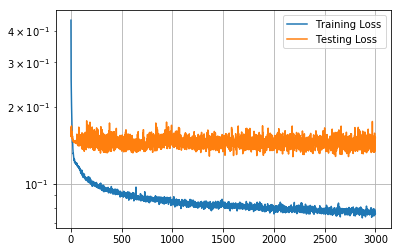

In [35]:
from matplotlib import pyplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

In [36]:
def rolling_seq_prediction(model,x_test,y_test):
    predictions = list()
    for i in x_test.index:
        # make one-step forecast
        X = x_test.loc[i].to_numpy().reshape(1,x_test.shape[1]) # reshape single line to have just 1 row
        y = y_test.loc[i]
        yhat = seq_model.predict(X).reshape(1,y_test.shape[1]) # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [37]:
yhat = rolling_seq_prediction(seq_model,x_test,y_test)
raw_seq_predictions = pd.DataFrame(yhat,columns = ['seq_call_prediction','seq_put_prediction'], index = test_index)

In [38]:
# Invert scaling for prediction data
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
unscaled_seq_predictions = pd.concat([x_test, test_data.google_45d], axis=1)
unscaled_seq_predictions = pd.concat([unscaled_seq_predictions, raw_seq_predictions], axis=1)
unscaled_seq_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_seq_predictions), columns=unscaled_seq_predictions.columns, index=unscaled_seq_predictions.index)

# Invert scaling for actual data
unscaled_data = pd.concat([x_test, test_data.google_45d], axis=1)
unscaled_data = pd.concat([unscaled_data, y_test], axis=1)
unscaled_data = pd.DataFrame(scaler.inverse_transform(unscaled_data), columns=unscaled_data.columns, index=unscaled_data.index)

In [39]:
backup['unscaled_seq_predictions'] = unscaled_seq_predictions
backup['unscaled_data'] = unscaled_data

In [40]:
unscaled_seq_predictions.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d,seq_call_prediction,seq_put_prediction
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1156.050049,0.012507,0.041908
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1161.219971,0.012507,0.041908
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1171.089966,0.012507,0.041908
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1186.869995,0.012507,0.041908
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1166.089966,0.015415,0.038637


In [41]:
unscaled_data.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d,short_call,short_put
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1156.050049,0.0,0.050285
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1161.219971,0.0,0.048188
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1171.089966,0.0,0.044905
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1186.869995,0.0,0.030105
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1166.089966,0.0,0.047911


In [42]:
seq_call_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.short_call, unscaled_seq_predictions.seq_call_prediction))
seq_put_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.short_put, unscaled_seq_predictions.seq_put_prediction))

/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


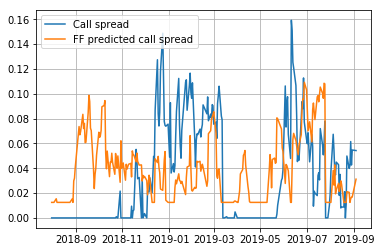

In [43]:
# Plot prediction vs actual call spread
plt.plot(unscaled_data['short_call'], label='Call spread')
plt.plot(unscaled_seq_predictions['seq_call_prediction'], label='FF predicted call spread')
plt.grid()
plt.legend()
plt.show()

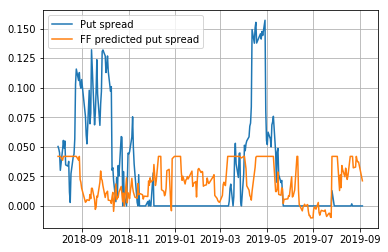

In [44]:
# Plot prediction vs actual put spread
plt.plot(unscaled_data['short_put'], label='Put spread')
plt.plot(unscaled_seq_predictions['seq_put_prediction'], label='FF predicted put spread')
plt.grid()
plt.legend()
plt.show()

### LSTM model

#### Split into train and test set
And here you have to be careful according to https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ :

"A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input. In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer. By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function."

But in order to can use "stateful = True" the data has to be a multiple of the batch size. Therefore I have to use modulo to get the test size correctly

In [45]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

In [46]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
# Reshape data for (Sample, Timesteps, Features)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_reshaped = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [47]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape = (x_train.shape[1], x_train.shape[2]), dropout = 0.2, return_sequences = True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 100, dropout = 0.2))
#lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(2))
lstm_model.compile(optimizer = 'adam', loss='mse')
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            56000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 136,602
Trainable params: 136,602
Non-trainable params: 0
_________________________________________________________________


In [48]:
start_lstm = time.time()
lstm_model.reset_states()
history=lstm_model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data=(x_test_reshaped, y_test));
end_lstm = time.time()
time_lstm = end_lstm - start_lstm
time_lstm

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2370 samples, validate on 270 samples
Epoch 1/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.1729 - val_loss: 0.1957
Epoch 2/100
2370/2370 [==============================] - 1s 514us/step - loss: 0.1312 - val_loss: 0.2105
Epoch 3/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.1274 - val_loss: 0.1556
Epoch 4/100
2370/2370 [==============================] - 2s 907us/step - loss: 0.1256 - val_loss: 0.1534
Epoch 5/100
2370/2370 [==============================] - 1s 579us/step - loss: 0.1247 - val_loss: 0.1395
Epoch 6/100
2370/2370 [==============================] - 2s 658us/step - loss: 0.1244 - val_loss: 0.1570
Epoch 7/100
2370/2370 [==============================] - 2s 677us/step - loss: 0.1234 - val_loss: 0.1498
Epoch 8/100
2370/2370 [==============================] - 1s 545us/step - loss: 0.1231 - val_loss: 0.1538
Epoch 9/100
2370/2370 [

Epoch 75/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.1050 - val_loss: 0.1521
Epoch 76/100
2370/2370 [==============================] - 2s 721us/step - loss: 0.1049 - val_loss: 0.1464
Epoch 77/100
2370/2370 [==============================] - 1s 504us/step - loss: 0.1051 - val_loss: 0.1549
Epoch 78/100
2370/2370 [==============================] - 1s 509us/step - loss: 0.1029 - val_loss: 0.1504
Epoch 79/100
2370/2370 [==============================] - 2s 813us/step - loss: 0.1043 - val_loss: 0.1500
Epoch 80/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.1048 - val_loss: 0.1450
Epoch 81/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.1041 - val_loss: 0.1504
Epoch 82/100
2370/2370 [==============================] - 2s 940us/step - loss: 0.1020 - val_loss: 0.1509
Epoch 83/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.1034 - val_loss: 0.1531
Epoch 84/100
2370/2370 [==============================

189.25162720680237

In [49]:
lstm_model.evaluate(x_train, y_train, batch_size=batch_size)

2370/2370 [==============================] - 1s 323us/step


0.08920533622650406

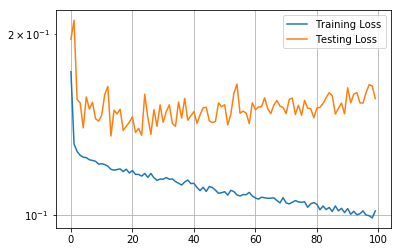

In [50]:
from matplotlib import pyplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()

#### Get predictions

In [51]:
def rolling_lstm_prediction(model,x_test,y_test):
    predictions = list()
    for i in range(len(x_test)):
        # make one-step forecast
        X = x_test[i,:] # select single line
        X = X.reshape(1, 1, len(X))  # reshape for LSTM
        y = y_test[i,:]
        yhat = lstm_model.predict(X, batch_size=1)
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [52]:
# Generate predictions
yhat = rolling_lstm_prediction(lstm_model,x_test,y_test);
raw_lstm_predictions = pd.DataFrame(yhat,columns = ['lstm_call_prediction','lstm_put_prediction'], index = test_index)

#### Convert data

In [53]:
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
y_test = pd.DataFrame(y_test, columns = ['short_call','short_put'], index = test_index)

In [54]:
# Invert scaling for prediction data
unscaled_lstm_predictions = pd.concat([x_test, test_data.google_45d], axis=1)
unscaled_lstm_predictions = pd.concat([unscaled_lstm_predictions, raw_lstm_predictions], axis=1)
unscaled_lstm_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_lstm_predictions), columns=unscaled_lstm_predictions.columns, index=unscaled_lstm_predictions.index)

# Invert scaling for actual data
test_data_unscaled = pd.concat([x_test, test_data.google_45d], axis=1)
test_data_unscaled = pd.concat([test_data_unscaled, y_test], axis=1)
test_data_unscaled = pd.DataFrame(scaler.inverse_transform(test_data_unscaled), columns=test_data_unscaled.columns, index=test_data_unscaled.index)

In [55]:
backup['unscaled_lstm_predictions'] = unscaled_lstm_predictions
backup['test_data_unscaled'] = test_data_unscaled

In [ ]:
backup.close()

In [56]:
lstm_call_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.short_call, unscaled_lstm_predictions.lstm_call_prediction))
lstm_put_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.short_put, unscaled_lstm_predictions.lstm_put_prediction))
print('Accuracy for short call spread of FF model is {} and of LSTM model is {} \nAccuracy for short cput spread of FF model is {} and of LSTM model is {}'.format(round(seq_call_accuracy,4), round(lstm_call_accuracy,4), round(seq_put_accuracy,4), round(lstm_put_accuracy,4)))

Accuracy for short call spread of FF model is 0.0437 and of LSTM model is 0.0412 
Accuracy for short cput spread of FF model is 0.0436 and of LSTM model is 0.045


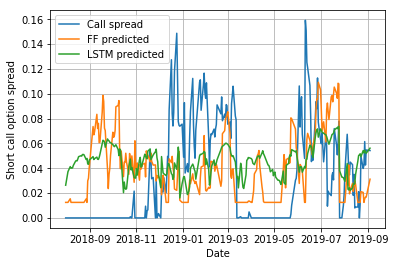

In [65]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['short_call'], label='Call spread')
plt.plot(unscaled_seq_predictions['seq_call_prediction'], label='FF predicted')
plt.plot(unscaled_lstm_predictions['lstm_call_prediction'], label='LSTM predicted')
plt.xlabel('Date')
plt.ylabel('Short call option spread')
plt.grid()
plt.legend()
plt.show()

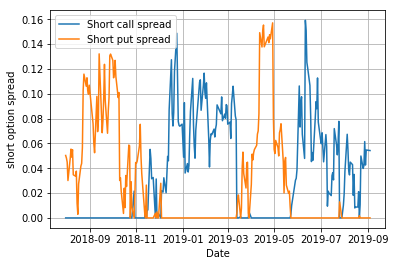

In [67]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['short_call'], label='Short call spread')
plt.plot(test_data_unscaled['short_put'], label='Short put spread')
plt.xlabel('Date')
plt.ylabel('short option spread')
plt.grid()
plt.legend()
plt.show()

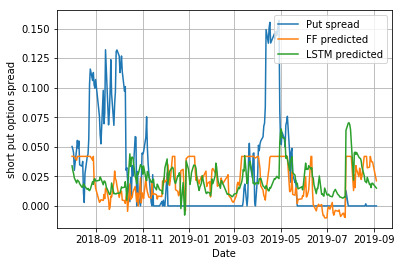

In [66]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['short_put'], label='Put spread')
plt.plot(unscaled_seq_predictions['seq_put_prediction'], label='FF predicted')
plt.plot(unscaled_lstm_predictions['lstm_put_prediction'], label='LSTM predicted')
plt.xlabel('Date')
plt.ylabel('short put option spread')
plt.grid()
plt.legend()
plt.show()

In [59]:
print('Run time for feedforward model is {} seconds \nRun time for LSTM model is {} seconds'.format(time_seq,time_lstm))

Run time for feedforward model is 242.43670320510864 seconds 
Run time for LSTM model is 189.25162720680237 seconds
